# Plane stress example

### Preamble

- Include the necesary modules from Julia's standard repositories.
- Here we run on 16 cores for parallel evaluation of the elements contribution to free energy, thus we need to import the Distributed module

In [1]:
using Distributed
using Statistics, LinearAlgebra
using Printf, WriteVTK, AbaqusReader
using PyCall, PyPlot, JLD, ProgressMeter

In [2]:
@everywhere include("adiff.jl")
@everywhere include("materials.jl")
@everywhere include("elements.jl")
;

this makes sure that the loop over the elements is split between 16 independent thread

In [3]:
@show Elements.setp(16)
;

Elements.setp(16) = 16


A few helper functions

In [4]:
# this function is the constraint equation for the internal holes
function cnst_func(u,ucntr,r0,cntr0,Rsq) 
    r    = r0+u
    cntr = cntr0+ucntr
    sum((r-cntr).^2)-Rsq
end
# this function find the centre of the constrained holes in the reference configuration
function find_centre(nodes; dTol = 1e-12, maxiter=21)

  c0    = mean(nodes)  
  bdone = false  
  iter  = 0

  while !bdone
    D2c0   = adiff.D2(c0)
    global deltas = [(D2c0[1]-p[1]).^2+(D2c0[2]-p[2]).^2 for p in nodes]
    r      = norm(deltas)
    grad   = adiff.grad(r)
    if (norm(grad)<dTol) || (iter>maxiter)
      bdone = true
    else
      c0  -= adiff.hess(r)\grad
    end
    iter +=1
  end
  Rsquares = adiff.val.(deltas) 
  return (c0, Rsquares)
end

# these functions write results for paraview visualization
function write_vtk_item(u0,sFileName)
    F   = Elements.getinfo(elems,u0,info=:F)
    J   = [det(F)                       for F  in F]
    C   = [transpose(F)*F               for F  in F]
    E   = [0.5*(C-I)                    for C  in C]
    L3  = [(F[1]F[4]-F[2]F[3])^-2       for F  in F]
    Ic  = [Materials.getInvariants(C[ii], L3[ii]) for ii in 1:nElems] 

    vtkobj  = vtk_grid(sFileName,points+u0[:,1:nNodes],cells)
    vtk_point_data(vtkobj, (u0[1,:],u0[2,:]), "u")
    vtk_cell_data(vtkobj,  J,   "J")
    vtk_cell_data(vtkobj,  tuple([getindex.(E,ii)   for ii in 1:4]...), "E")
    vtk_cell_data(vtkobj,  tuple([getindex.(F,ii)   for ii in 1:4]...), "F")
    vtk_cell_data(vtkobj,  tuple([getindex.(Ic,ii)  for ii in 1:3]...), "I")
    vtk_save(vtkobj)        
    return vtkobj
end
    
function write_to_vtk_file(allus, sFileName)
    p = ProgressMeter.Progress(length(allus), desc="saving to "*sFileName*".pvd - ")
    paraview_collection(sFileName) do pvd
      for (ii, item) in enumerate(allus)
        vtkobj = write_vtk_item(item[1],@sprintf("%s_%03i", sFileName, ii))
        collection_add_timestep(pvd, vtkobj, ii)
        ProgressMeter.next!(p)
      end
    end  
end
    
# some plotting functions
patch = pyimport("matplotlib.patches")
coll  = pyimport("matplotlib.collections")  

function plot_model(elems, nodes; 
                    u = zeros(length(nodes[1]), length(nodes)),
                    Φ = [],
                    linewidth = 0.25,
                    facecolor = :c,
                    edgecolor = :b, 
                    alpha     = 1,
                    cmap      = :hsv,
                    clim      = [],
                    dTol      = 1e-6,
                    cfig      = figure())

  nodes     = [node + u[:,ii] for (ii,node) in enumerate(nodes)]
  patchcoll = coll.PatchCollection([patch.Polygon(nodes[elem.nodes]) 
                                    for elem ∈ elems], cmap=cmap)
  ax = cfig.add_subplot(1,1,1)
  if !isempty(Φ)
    patchcoll.set_array(Φ)
    cfig.colorbar.(patchcoll, ax=ax)

    if isempty(clim)
      clim = patchcoll.get_clim()
      if abs(clim[2]-clim[1]) < dTol
        clim  = sum(clim)/2*[0.9, 1.1]
      end
    end
    patchcoll.set_clim(clim)
  else
    patchcoll.set_color(facecolor)
  end

  patchcoll.set_edgecolor(edgecolor)
  patchcoll.set_alpha(alpha)
  patchcoll.set_linewidth(linewidth)

  ax.set_aspect("equal")
  ax.add_collection(patchcoll)
  ax.autoscale()
  return (cfig, ax, patchcoll)
end
function plot_I1(elems, nodes, u0)
    F   = Elements.getinfo(elems,u0,info=:F)
    J   = [det(F)                       for F  in F]
    C   = [transpose(F)*F               for F  in F]
    L3  = [(C[1]C[4]-C[2]C[3])^-1       for C  in C]
    Ic  = [Materials.getInvariants(C[ii], L3[ii]) for ii in 1:nElems] 

    I1  = [item[1]-3 for item in Ic]

    cfig = PyPlot.figure()
    plot_model(elems, nodes, alpha=0.05, facecolor=:c, edgecolor=:c, cfig=cfig)
    plot_model(elems, nodes, u = u0, facecolor=:c, edgecolor=:c, Φ = I1, cfig=cfig)
end 
;

A few parameters controlling the simulation, file naming, output produced etc, are set

In [5]:
sMeshFile = "Pattern2D03FinerMesh02j.inp"
ϵn0       = 0.24
bfside    = true
mat       = Materials.NeoHooke(10)
bVTKall   = true
maxiter   = 10
dTol      = 1e-8
sVTKpath  = "./vtk_files/"
bprogress = false
bwarmup   = true
blheqs    = false
bsheqs    = true
;

Load the mesh and store node sets

In [6]:
mymodel   = AbaqusReader.abaqus_read_mesh(sMeshFile)
@printf("\n\t loaded %s \n", sMeshFile)

(xmin, xmax) = extrema([item[2][1] for item ∈ mymodel["nodes"]])
(ymin, ymax) = extrema([item[2][2] for item ∈ mymodel["nodes"]])

nodes    = [mymodel["nodes"][ii]    for ii ∈ 1:length(mymodel["nodes"])]
el_nodes = [mymodel["elements"][ii] for ii ∈ 1:length(mymodel["elements"])]

elems = []
for item ∈ el_nodes
if length(item)==3
  push!(elems, Elements.Tria(item, nodes[item], mat=mat))
elseif length(item)==4
  push!(elems, Elements.Quad(item, nodes[item], mat=mat))
end
end    

points   = hcat(nodes...)
cells    = [if length(nodes)==3
            MeshCell(VTKCellTypes.VTK_TRIANGLE, nodes)
          else length(nodes)==4
            MeshCell(VTKCellTypes.VTK_QUAD, nodes)
          end  for nodes in el_nodes ]

@show nNodes, nElems  = length(nodes), length(el_nodes)
@show Δx, Δy          = (xmax-xmin), (ymax-ymin)

nid_bndl = mymodel["node_sets"]["ID_L"]
nid_bndr = mymodel["node_sets"]["ID_R"]
nid_bndt = mymodel["node_sets"]["ID_T"]
nid_bndb = mymodel["node_sets"]["ID_B"]

nid_sh01 = mymodel["node_sets"]["ID_SH01"]
nid_sh02 = mymodel["node_sets"]["ID_SH02"]
nid_sh03 = mymodel["node_sets"]["ID_SH03"]
nid_sh04 = mymodel["node_sets"]["ID_SH04"]
nid_sh05 = mymodel["node_sets"]["ID_SH05"]
nid_sh06 = mymodel["node_sets"]["ID_SH06"]
nid_sh07 = mymodel["node_sets"]["ID_SH07"]
nid_sh08 = mymodel["node_sets"]["ID_SH08"]
nid_sh09 = mymodel["node_sets"]["ID_SH09"]

nid_shx  = [nid_sh01, nid_sh02, nid_sh03,
          nid_sh04, nid_sh05, nid_sh06,
          nid_sh07, nid_sh08, nid_sh09]
nSHs     = length(nid_shx)

nid_lh01 = mymodel["node_sets"]["ID_LH01"]
nid_lh02 = mymodel["node_sets"]["ID_LH02"]
nid_lh03 = mymodel["node_sets"]["ID_LH03"]
nid_lh04 = mymodel["node_sets"]["ID_LH04"]
nid_lh05 = mymodel["node_sets"]["ID_LH05"]
nid_lh06 = mymodel["node_sets"]["ID_LH06"]
nid_lh07 = mymodel["node_sets"]["ID_LH07"]
nid_lh08 = mymodel["node_sets"]["ID_LH08"]
nid_lh09 = mymodel["node_sets"]["ID_LH09"]
nid_lh10 = mymodel["node_sets"]["ID_LH10"]
nid_lh11 = mymodel["node_sets"]["ID_LH11"]
nid_lh12 = mymodel["node_sets"]["ID_LH12"]
nid_lh13 = mymodel["node_sets"]["ID_LH13"]
nid_lh14 = mymodel["node_sets"]["ID_LH14"]
nid_lh15 = mymodel["node_sets"]["ID_LH15"]
nid_lh16 = mymodel["node_sets"]["ID_LH16"]

nid_lhx  = [nid_lh01, nid_lh02, nid_lh03,
          nid_lh04, nid_lh05, nid_lh06,
          nid_lh07, nid_lh08, nid_lh09, nid_lh10,
          nid_lh11, nid_lh12, nid_lh13,
          nid_lh14, nid_lh15, nid_lh16]
nLHs     = length(nid_lhx)

cntrs_s = [find_centre(nodes[idx]) for idx in nid_shx]
cntrs_l = [find_centre(nodes[idx]) for idx in nid_lhx]
nodes = vcat(nodes,getindex.(cntrs_s,1),getindex.(cntrs_l,1))
;

┌ Info: 11678 nodes found
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:103
┌ Info: Parsing elements. Type: CPS4. Topology: Quad4
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:147
┌ Info: Creating nset ID_L
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating elset ID_L
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating nset ID_R
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating elset ID_R
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating nset ID_T
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating elset ID_T
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating nset ID_B
└ @ AbaqusReader /u1/vian294/.julia/pack


	 loaded Pattern2D03FinerMesh02j.inp 
(nNodes, nElems) = (length(nodes), length(el_nodes)) = (11678, 10832)
(Δx, Δy) = (xmax - xmin, ymax - ymin) = (20.0, 20.0)


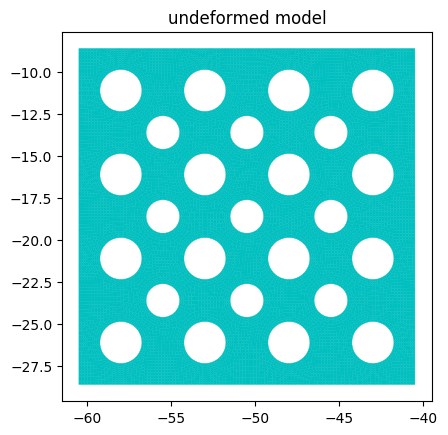

In [7]:
plot_model(elems, nodes, facecolor=:c, edgecolor=:c)
PyPlot.title("undeformed model")
;

Write constraint equations for the holes:
 - if bsheqs is true eqautions are added for the smaller holes
 - if blheqs is true equations are added for the larger holes

In [8]:
idxs  = LinearIndices(((2, nNodes+nSHs+nLHs)))
eqns  = Array{Elements.ConstEq}(undef, 0)
if bsheqs
    eqns  = vcat(eqns,
                 [ [ begin
                      r0      = nodes[nid]
                      cntr0   = nodes[nNodes+ii]
                      Rsq     = cntrs_s[ii][2][jj]
                      id_dofs = vcat(idxs[:,nid][:],idxs[:,nNodes+ii][:])
                      Elements.ConstEq(x->cnst_func(x[1:2],x[3:4],r0,cntr0,Rsq), 
                                       id_dofs,adiff.D2) 
                    end  for (jj,nid) in enumerate(nid_ii)] 
                  for (ii,nid_ii) in enumerate(nid_shx)]...)
end
if blheqs
    eqns = vcat(eqns,
                [ [ begin
                     r0      = nodes[nid]
                     cntr0   = nodes[nNodes+nSHs+ii]
                     Rsq     = cntrs_l[ii][2][jj]
                     id_dofs = vcat(idxs[:,nid][:],idxs[:,nNodes+nSHs+ii][:])
                     Elements.ConstEq(x->cnst_func(x[1:2],x[3:4],r0,cntr0,Rsq), 
                                      id_dofs,adiff.D2) 
                   end  for (jj,nid) in enumerate(nid_ii)] 
                 for (ii,nid_ii) in enumerate(nid_lhx)]... )
end
;

prepare a few arrays needed to start the solution
- u is the displacement vector, it contains the boundary conditions,
- ifree is an array of boolean with the same dimension of u, if ifree is true that DoFs is free, otherwise it is constrained, and the value of the constraint is stored in u

### Do the compressive branch

- define the increments, LF is the array with the load factor for each increment

In [9]:
ϵn        = -ϵn0
sPosFix   = "NHc_100inc"
N1        = 100
N2        = 50
LF        = vcat(range(1/N1/10, 0.90-1/N1, length=N1), 
                 range(0.90, 1, length=N2))
;

- initialize the displacement vector and the boundary conditions: u is the array with the DoFs, the NaN entries in u are free DoFs, the !NaN entries are the boundary conditions

In [10]:
u                  = fill(NaN, 2, nNodes+nSHs+nLHs)
u[:,nid_bndb]     .= 0
u[1,nid_bndt]     .= 0 
u[2,nid_bndt]     .= ϵn*Δy

if !bsheqs u[:,nNodes+1:nNodes+nSHs] .= NaN; end
if !blheqs u[:,nNodes+nSHs+1:end]    .= NaN; end

if !bfside
    u[1,nid_bndl]     .= 0 
    u[1,nid_bndr]     .= 0 
end

ifree     = isnan.(u)
icnst     = .!ifree
;

- this is a preliminary step, for making sure all constranints are initially satisfied and avoid non-convergence on the first step, the result is used as initial condition for the simulation

In [11]:
if bwarmup
    u0        = 1e-4Δx*randn(2, nNodes+nSHs+nLHs)
    u0[icnst] .= 1e-4u[icnst]
    @time Elements.solvestep!(elems, u0, ifree,
                              bprogress=false, eqns=eqns, λ = zeros(length(eqns)),
                              becho=true, maxiter=maxiter, dTol=dTol)
    u[ifree] .= u0[ifree]
end
;


iter:  1, norm0: 2.36e-03, normr/dTol: 8.61e+07, eltime: 11.80 sec. 
iter:  2, norm0: 1.26e-04, normr/dTol: 3.95e+07, eltime: 6.41 sec. 
iter:  3, norm0: 6.49e-06, normr/dTol: 2.41e+06, eltime: 6.11 sec. 
iter:  4, norm0: 6.50e-06, normr/dTol: 8.46e+01, eltime: 6.04 sec. 
iter:  5, norm0: 6.50e-06, normr/dTol: 3.59e-02, eltime: 2.47 sec. 
 37.986003 seconds (42.94 M allocations: 29.769 GiB, 7.86% gc time)


- solve the model 

In [12]:
sFileName = splitext(sMeshFile)[1]*sPosFix
@printf("\n\t starting %s \n", sFileName); flush(stdout)
allus_c = Elements.solve(elems, u, 
                     ifree=ifree, eqns=eqns,
                     LF=LF, bprogress=bprogress,
                     becho=!bprogress, bechoi=!bprogress, ballus=true, 
                     maxiter = maxiter, dTol=dTol)

rf_tot_c = [sum(item[2][2,nid_bndt])   for item in allus_c]
Δu_tot_c = [mean(item[1][2,nid_bndt])  for item in allus_c]
;


	 starting Pattern2D03FinerMesh02jNHc_100inc 

iter:  1, norm0: 5.05e-03, normr/dTol: 3.72e+06, eltime: 5.52 sec. 
iter:  2, norm0: 2.63e-04, normr/dTol: 3.02e+06, eltime: 5.72 sec. 
iter:  3, norm0: 6.52e-05, normr/dTol: 2.51e+04, eltime: 5.56 sec. 
iter:  4, norm0: 6.50e-05, normr/dTol: 2.23e-01, eltime: 2.46 sec. 
step  1 done in  4 iter, after 19.78 sec.

iter:  1, norm0: 8.78e-02, normr/dTol: 3.72e+06, eltime: 6.37 sec. 
iter:  2, norm0: 2.72e-02, normr/dTol: 3.68e+06, eltime: 5.62 sec. 
iter:  3, norm0: 5.16e-03, normr/dTol: 3.42e+06, eltime: 6.27 sec. 
iter:  4, norm0: 7.84e-04, normr/dTol: 1.15e+06, eltime: 5.64 sec. 
iter:  5, norm0: 6.51e-04, normr/dTol: 5.32e+03, eltime: 6.23 sec. 
iter:  6, norm0: 6.51e-04, normr/dTol: 1.25e-01, eltime: 2.38 sec. 
step  2 done in  6 iter, after 32.52 sec.

iter:  1, norm0: 8.86e-02, normr/dTol: 3.70e+06, eltime: 5.35 sec. 
iter:  2, norm0: 2.77e-02, normr/dTol: 3.62e+06, eltime: 6.17 sec. 
iter:  3, norm0: 5.64e-03, normr/dTol: 3.15e+06, e

- save results to a .JLD file

In [24]:
JLD.save(sFileName*".jld",
            "nodes", nodes, "elems", elems, "allus", allus_c,
            "points", points, "cells", cells, "LF", LF, "mat", mat,
            "Nsteps", length(LF), "nid_bndl", nid_bndl, "nid_bndr", nid_bndr, 
            "nid_bndt", nid_bndt, "nid_bndb", nid_bndb, 
            "u", u, "rf_tot", rf_tot_c, "Δu_tot", Δu_tot_c,
            "cntrs_s", cntrs_s, "cntrs_l", cntrs_l,
            "nid_shx", nid_shx, "nid_lhx", nid_lhx,
            "Δx", Δx, "Δy", Δy, "nNodes", nNodes, "nElems", nElems,
            "sMeshFile", sMeshFile, "sFileName", sFileName, "sVTKpath", sVTKpath)
# @printf("results written to %s\n", sFileName); flush(stdout)
;

- plot the results

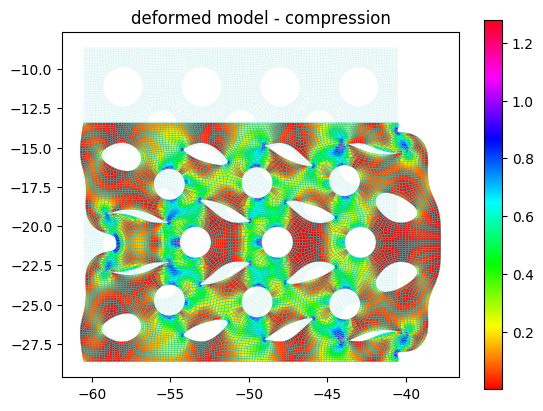

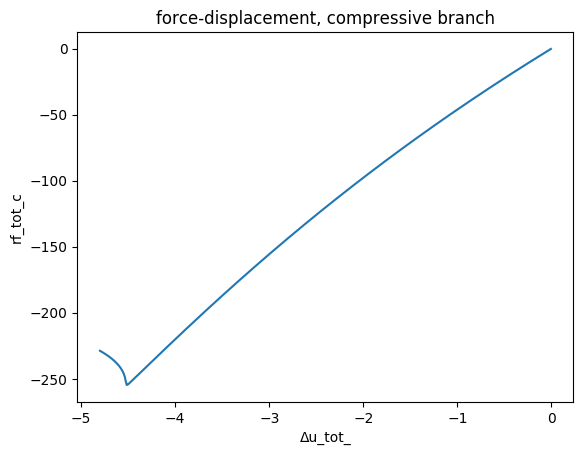

/u1/vian294/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [14]:
plot_I1(elems, nodes, allus_c[end][1])
PyPlot.title("deformed model - compression")

PyPlot.figure()
PyPlot.plot(Δu_tot_c, rf_tot_c)
PyPlot.xlabel("Δu_tot_")
PyPlot.ylabel("rf_tot_c")
PyPlot.title("force-displacement, compressive branch")
;

In [15]:
if bVTKall
    write_to_vtk_file(allus_c, sVTKpath*sFileName)
else  
    write_vtk_item(allus_c[end][1], sVTKpath*sFileName)
end
;

saving to ./vtk_files/Pattern2D03FinerMesh02jNHc_100inc.pvd - 100% Time: 0:01:01


### Do the tensile branch

In [16]:
ϵn        = ϵn0
sPosFix   = "NHt_100inc"
N         = 50
LF        = range(1/N/10, 1.0, length=N)
;

In [17]:
u                  = fill(NaN, 2, nNodes+nSHs+nLHs)
u[:,nid_bndb]     .= 0
u[1,nid_bndt]     .= 0 
u[2,nid_bndt]     .= ϵn*Δy

if !bsheqs u[:,nNodes+1:nNodes+nSHs] .= NaN; end
if !blheqs u[:,nNodes+nSHs+1:end]    .= NaN; end

if !bfside
    u[1,nid_bndl]     .= 0 
    u[1,nid_bndr]     .= 0 
end

ifree     = isnan.(u)
icnst     = .!ifree
;

In [18]:
if bwarmup
    u0        = 1e-4Δx*randn(2, nNodes+nSHs+nLHs)
    u0[icnst] .= 1e-4u[icnst]
    @time Elements.solvestep!(elems, u0, ifree,
                              bprogress=false, eqns=eqns, λ = zeros(length(eqns)),
                              becho=true, maxiter=maxiter, dTol=dTol)
    u[ifree] .= u0[ifree]
end
;


iter:  1, norm0: 2.21e+00, normr/dTol: 2.13e+09, eltime: 6.62 sec. 
iter:  2, norm0: 6.02e-02, normr/dTol: 1.92e+09, eltime: 6.31 sec. 
iter:  3, norm0: 3.00e-03, normr/dTol: 1.19e+08, eltime: 6.19 sec. 
iter:  4, norm0: 3.00e-03, normr/dTol: 3.93e+03, eltime: 6.16 sec. 
iter:  5, norm0: 3.00e-03, normr/dTol: 6.19e-03, eltime: 2.49 sec. 
 27.778117 seconds (19.38 M allocations: 28.687 GiB, 10.24% gc time)


In [19]:
sFileName = splitext(sMeshFile)[1]*sPosFix
@printf("\n\t starting %s \n", sFileName); flush(stdout)
allus_t = Elements.solve(elems, u,
                     ifree=ifree, eqns=eqns,
                     LF=LF, bprogress=bprogress,
                     becho=!bprogress, bechoi=!bprogress, ballus=true, 
                     maxiter = maxiter, dTol=dTol)

rf_tot_t = [sum(item[2][2,nid_bndt])   for item in allus_t]
Δu_tot_t = [mean(item[1][2,nid_bndt])  for item in allus_t]
;


	 starting Pattern2D03FinerMesh02jNHt_100inc 

iter:  1, norm0: 8.09e+00, normr/dTol: 1.00e+08, eltime: 6.10 sec. 
iter:  2, norm0: 7.63e-01, normr/dTol: 1.05e+08, eltime: 5.70 sec. 
iter:  3, norm0: 5.70e-02, normr/dTol: 1.23e+07, eltime: 5.76 sec. 
iter:  4, norm0: 6.00e-02, normr/dTol: 1.11e+03, eltime: 5.94 sec. 
iter:  5, norm0: 6.00e-02, normr/dTol: 3.04e-04, eltime: 2.54 sec. 
step  1 done in  5 iter, after 26.04 sec.

iter:  1, norm0: 5.19e+01, normr/dTol: 9.99e+07, eltime: 5.95 sec. 
iter:  2, norm0: 1.20e+02, normr/dTol: 1.00e+08, eltime: 6.09 sec. 
iter:  3, norm0: 4.19e+01, normr/dTol: 1.01e+08, eltime: 5.65 sec. 
iter:  4, norm0: 1.05e+01, normr/dTol: 1.04e+08, eltime: 6.12 sec. 
iter:  5, norm0: 1.30e+00, normr/dTol: 1.05e+08, eltime: 5.93 sec. 
iter:  6, norm0: 6.62e-01, normr/dTol: 5.47e+06, eltime: 5.76 sec. 
iter:  7, norm0: 6.67e-01, normr/dTol: 6.10e+03, eltime: 5.81 sec. 
iter:  8, norm0: 6.67e-01, normr/dTol: 1.11e-02, eltime: 2.58 sec. 
step  2 done in  8 iter, 

In [20]:
JLD.save(sFileName*".jld",
            "nodes", nodes, "elems", elems, "allus", allus_t,
            "points", points, "cells", cells, "LF", LF, "mat", mat,
            "Nsteps", length(LF), "nid_bndl", nid_bndl, "nid_bndr", nid_bndr, 
            "nid_bndt", nid_bndt, "nid_bndb", nid_bndb, 
            "u", u, "rf_tot", rf_tot_t, "Δu_tot", Δu_tot_t,
            "cntrs_s", cntrs_s, "cntrs_l", cntrs_l,
            "nid_shx", nid_shx, "nid_lhx", nid_lhx,
            "Δx", Δx, "Δy", Δy, "nNodes", nNodes, "nElems", nElems,
            "sMeshFile", sMeshFile, "sFileName", sFileName, "sVTKpath", sVTKpath)
@printf("results written to %s\n", sFileName); flush(stdout)
;

results written to Pattern2D03FinerMesh02jNHt_100inc


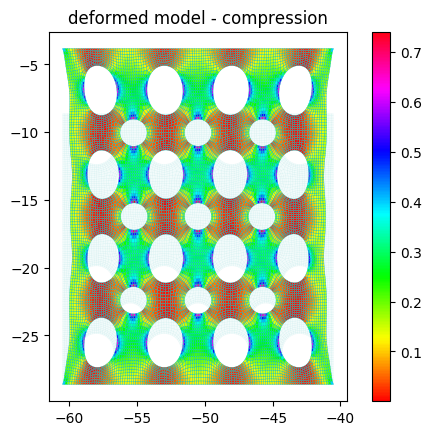

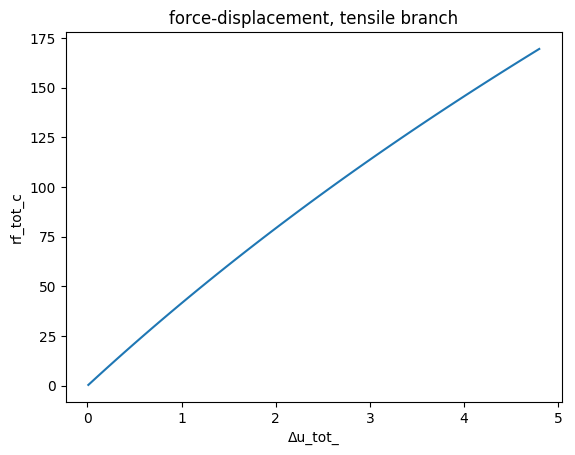

In [21]:
plot_I1(elems, nodes, allus_t[end][1]  )
PyPlot.title("deformed model - compression")

PyPlot.figure()
PyPlot.plot(Δu_tot_t, rf_tot_t)
PyPlot.xlabel("Δu_tot_")
PyPlot.ylabel("rf_tot_c")
PyPlot.title("force-displacement, tensile branch")
;

In [22]:
if bVTKall
    write_to_vtk_file(allus_t, sVTKpath*sFileName)
else  
    write_vtk_item(allus_t[end][1], sVTKpath*sFileName)
end
;

saving to ./vtk_files/Pattern2D03FinerMesh02jNHt_100inc.pvd - 100% Time: 0:00:18


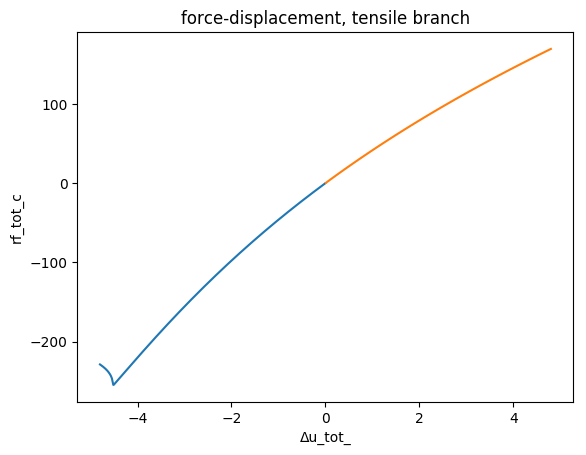

PyObject Text(0.5,1,u'force-displacement, tensile branch')

In [23]:
PyPlot.figure()
PyPlot.plot(Δu_tot_c, rf_tot_c, 
Δu_tot_t, rf_tot_t)
PyPlot.xlabel("Δu_tot_")
PyPlot.ylabel("rf_tot_c")
PyPlot.title("force-displacement, tensile branch")